# Banded ridge regression example

In this example, we model fMRI responses in a Neuroscout dataset using *banded ridge regression*.

Banded ridge regression allows you to fit and optimize a distinct regularization hyperparameters for each group or "band" of feature spaces. This is useful if you want to jointly fit two feature space sets. We can then also estimate the relative contribution of each feature set to our prediction for each voxel.

This example assumes that you have already worked through the basic ridge regression example, which demonstrates how to use `pyns.fetch_utils` to retrieve Neuroscout predictor and neuroimaging data for model fitting.
For a comprehensive tutorial, check out the excellent [voxelwise modeling tutorials](https://gallantlab.github.io/voxelwise_tutorials/index.html) from the Gallant Lab.

__Note__: By implementing a custom pipeline, your analysis will not be centrally registered on neuroscout.org, and a reproducible record will not be made. For analyses supported the Neuroscout-CLI (e.g. group voxelwise mass univariate GLM models), it is recommended to use the neuroscout.org web inteface, or follow the guide for programmatically [creating analyses 
using pyNS](https://pyns.readthedocs.io/en/latest/analyses.html).

### Citing Neuroscout

If you publish any results using the Neuroscout data, be sure to cite the Neuroscout paper, and corresponding datasets:

    Alejandro de la Vega, Roberta Rocca, Ross W Blair, Christopher J Markiewicz, Jeff Mentch, James D Kent, Peer Herholz, Satrajit S Ghosh, Russell A Poldrack, Tal Yarkoni (2022). *Neuroscout, a unified platform for generalizable and reproducible fMRI research*. eLife 11:e79277. https://doi.org/10.7554/eLife.79277
    
    Visconti di Oleggio Castello, M., Chauhan, V., Jiahui, G., & Gobbini, M. I. An fMRI dataset in response to “The Grand Budapest Hotel”, a socially-rich, naturalistic movie. Sci Data 7, 383 (2020). https://doi.org/10.1038/s41597-020-00735-4

If running this notebook on Google Colab, be sure to switch the runtime to GPU to expedite model ftting (Runtime -> Change runtime type)

In [ ]:
#@title 1) Run once to install dependencies on Colab (pyNS, Datalad, and Machine Learning libraries) (~1 minute)
%%capture --no-display --no-stderr
from IPython.display import display
display("Installing NeuroDebian...")

## Set up DataLad
!wget -O- http://neuro.debian.net/lists/focal.us-ca.libre | sudo tee /etc/apt/sources.list.d/neurodebian.sources.list && sudo apt-key adv --recv-keys --keyserver hkps://keyserver.ubuntu.com 0xA5D32F012649A5A9 && sudo apt-get update
display("Installing DataLad...")

!sudo apt-get install datalad -y
%pip install -U datalad
!git config --global user.email "you@example.com" && git config --global user.name "Your Name"

display("Installing PyNS...")
%pip install pyns
%pip install git+https://github.com/bids-standard/pybids.git#egg=pybids

display("Installing analysis dependencies (nilearn, and himalaya)...")
%pip install nilearn himalaya

display("Done.")

## Fetching Neuroscout Data

For this example, we'll build on our previous example, and focus on a single subject from the `Budapest` dataset, in which subjects watched the movie "The Grand Budapest Hotel".

See the previous example to learn how to browse which datasets and features are available.

First, we define the dataset name, and subject we want to analyze:

In [1]:
dataset_name = 'Budapest'
subject = 'sid000005'
runs = [1, 2, 3]

Next we define the names of the features we want to analyze.

We will fetch two sets of predictors: [Mel spetrogram](https://neuroscout.org/predictor/mel_0), and  [Mel Frequency Cepstral Coefficient (MFCC)](https://neuroscout.org/predictor/mfcc_0).

In addition, we will also fetch 7 nuisance regressors: `framewise_displacement`, `trans_x`, `trans_y`, `trans_z`, `rot_x`, and `rot_y`.

In [2]:
mfccs = [f'mfcc_{i}' for i in range(20)]
mel = [f'mel_{i}' for i in range(64)]
confounds = ['rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z']

all_vars = mfccs + mel + confounds

Next, we'll use `pyns.fetch_predictors` to retrieve these predictors for the target subject, rescale to unit variance, and resampl to the imaging data's Repetition Time (TR).

Since downloading and resampling can take a minute, for this example we'll only use the first three (out of 8) runs.

In [3]:
from pyns.fetch_utils import fetch_predictors, fetch_images

predictors = fetch_predictors(all_vars, dataset_name=dataset_name, subject=subject, run=runs, rescale=True, resample=True)

/home/alejandro/miniconda3/envs/nsencoding/lib/python3.10/site-packages/pyns/endpoints/base.py:135: UserWarning: No API endpoint for stimulus_id, could not convert
  warnings.warn(f"No API endpoint for {col}, could not convert")


Finally, we load the corresponding images:

In [4]:
# Note: This command can hang after fetching images. 
# If so, stop this cell and re-run, and it will immediately re-execute
preproc_dir, img_objs = fetch_images('Budapest', '/tmp/', subject=subject, run=runs)

/home/alejandro/miniconda3/envs/nsencoding/lib/python3.10/site-packages/bids/layout/validation.py:48: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "
/home/alejandro/miniconda3/envs/nsencoding/lib/python3.10/site-packages/bids/layout/validation.py:122: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


action summary:
  get (notneeded: 6)


## Preprocessing Images

To preprocess the images, we must then:

1) Define a mask to apply
2) Stack masked images into a single numpy array

This time, we will use a apriori ROI to restrict the voxels to reduce computational time.

In this case, we will use a mask of the Superior Temporal Gyrus based on the Harvard-Oxford atlas, as we hypothesize that auditory processing relevant to our predictors should occur in this area.

/tmp/ipykernel_3687308/3687408342.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  atlas_data = atlas.get_data()
/tmp/ipykernel_3687308/3687408342.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  stg = nilearn.image.new_img_like(atlas, (atlas_data == stg_p_ix) | (atlas_data == stg_a_ix))
/home/alejandro/miniconda3/envs/nsencoding/lib/python3.10/site-packages/nilearn/image/resampling.py:274: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


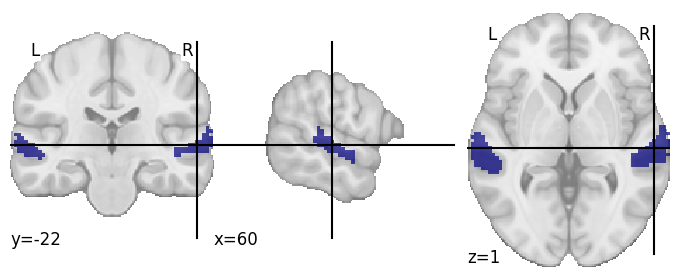

In [87]:
# Use nilearn to compute STG mask for both posterior and anterior divison
from nilearn import plotting, datasets, image
import nibabel as nib

dataset_ho = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")

# Extract both ROIs and combine
stg_p_ix = np.where(np.array(dataset_ho['labels']) == 'Superior Temporal Gyrus, posterior division')[0]
stg_a_ix = np.where(np.array(dataset_ho['labels']) == 'Superior Temporal Gyrus, anerior division')[0]
atlas_data = atlas.get_data()
stg = nilearn.image.new_img_like(atlas, (atlas_data == stg_p_ix) | (atlas_data == stg_a_ix))

# Downsample STG mask to functional sapce
resampled_stg = nilearn.image.resample_img(stg, all_funcs[0].get_image().affine, (78, 93, 78))

plotting.plot_roi(resampled_stg)

Now using this STG mask, we can mask our functional BOLD timecourses, and stack them together into a single dataframer

In [88]:
# Only grab bold images
all_funcs = [f for f in img_objs if f.entities['suffix'] == 'bold']

# Mask images and stack into a single array
import pandas as pd
from nilearn.maskers import NiftiMasker

def _mask_and_stack_images(image_objects, mask):
    """ Stack images into single array, and collect metadata entities into DataFrame """
    masker = NiftiMasker(mask_img=mask)

    arrays = []
    entities = []
    image_objects = sorted(image_objects, key=lambda x: x.entities['run'])
    for img in image_objects:
        run_y = masker.fit_transform(img)
        arrays.append(run_y)
        entities += [dict(img.entities)] * run_y.shape[0]
    entities = pd.DataFrame(entities)
    return np.vstack(arrays), entities, masker

y, img_entities, masker = _mask_and_stack_images(all_funcs, resampled_stg)

The stacked runs have shape: `(n_volumes, n_voxels)`

In [89]:
y.shape

(1631, 943)

## Fitting a banded (or grouped) ridge regression model

To fit both Mel spectrogram and MFCC features jointly in the same run, we must modify our previous workflow to have the concept of "bands", or groups of features.

The following workflow assumes a single pandas DataFrame that includes all of the features (`X_vars`). For a banded model, you additionally need to specify `bands` which is a list of lists, where each sublist contains the names of the features in that band.

In this example, we will use the Mel spectrogram features as the first band, and the MFCC features as the second band.

In addition, we can specify a list of `confounds` to be included in the model, but not used for prediction. This is useful if you want to include nuisance regressors in the model, but not use them to predict voxelwise activity.

Finally, the `split` parameter allows us to adjust model scores in such a way to to disentangle the contribution of the two feature spaces. Split scoring computes the prediction for each feature space separately, and corrects the resulting scores so that the sum of scores from distinct feature spaces sum to the scores of the full prediction. This can be helpful to understand which feature space is *better* at predicting activity in a given voxel. 

To learn more, please see the [banded ridge regression example](https://gallantlab.org/voxelwise_tutorials/_auto_examples/shortclips/06_plot_banded_ridge_model.html#sphx-glr-auto-examples-shortclips-06-plot-banded-ridge-model-py) in the Gallant lab voxlelwise modeling tutorials.

The following working `_model_cv` expands on the previous example with the addition of the `bands`, `split` and `confounds` parameters.

In [90]:
from collections import defaultdict
from himalaya.scoring import correlation_score

def _model_cv(estimator, cv, X_vars, y, bands=None, confounds=None,groups=None,
    scoring=correlation_score, split=True, inner_cv=None):
    """ Cross-validate a model on a set of variables.

    Parameters
    ----------
    estimator : Scikit-learn like estimator
        Estimator to use for fitting the model. Must have a fit and predict
        method.
    cv : cross-validation generator or an iterable
        Outer cross-validation generator to use for cross-validation.
    X_vars : pandas.DataFrame
        Dataframe containing the variables to use for prediction.
    y : array-like, shape (n_samples, n_targets)
        Target values.
    bands : list of str, optional
        List of bands to use for prediction. If None, all of X_vars will be
        used.
    confounds : list of str, optional
        List of confounds to use for prediction. Confounds will be removed
        from the model coefficients prior to scoring.
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set.
    scoring : callable, optional  (default: correlation_score)
        Scoring function to use for evaluating the model.
    split : bool, optional (default: True)
        If True, the prediction will be split by band.
    inner_cv : cross-validation generator or an iterable, optional
        Inner cross-validation generator to use for cross-validation.
    """

    # Container for results
    results = defaultdict(list)

    if bands is not None:
        X = []
        for band in bands:
            X.append(X_vars[band].values)

        # If confounds, stack at the end
        if confounds is not None:
            bands.append(confounds)
    else:
        X = X_vars.as_matrix()

        if confounds is not None:
            X = np.hstack([X, confounds])

    # Extract data from dataframe
    X = X_vars.values

    # Extract number of samples for convenience
    n_samples = y.shape[0]

    # Loop through outer cross-validation folds
    for train, test in cv.split(np.arange(n_samples), groups=groups):
        
        # Get training model for list of model bands
        
        X_train = [x[train] for x in X] if type(X) == list else X[train]
        X_test = [x[test] for x in X] if type(X) == list else X[test]
        
        # Create inner cross-validation loop if specified
        if inner_cv:
            # Split inner cross-validation with groups if supplied
            inner_groups = np.array(groups)[train] if groups else groups
            inner_splits = inner_cv.split(np.arange(n_samples)[train],
                                            groups=inner_groups)
            
            # Update estimator with inner cross-validator
            estimator.set_params(cv=inner_splits)

        # Fit the regression model on training data
        estimator.fit(X_train, y[train])

        # Zero out coefficients for confounds if provided
        if confounds is not None:
            estimator.dual_coef_[-len(confounds):] = 0
    
        # Compute predictions with optional splitting by band
        kwargs = {}
        if split is not None:
            kwargs['split'] = split

        test_prediction = estimator.predict(X_test, **kwargs)
        
        # Test scores
        test_score = scoring(y[test], test_prediction)
        
        # Test scores
        test_score = scoring(y[test], test_prediction)

        # If output is not an array, assume its a torch Tensor and convert to array
        if not isinstance(test_prediction, np.ndarray):
            test_prediction = test_prediction.cpu().numpy()
            test_score = test_score.cpu().numpy()
            
        # Populate results dictionary
        results['test_predictions'].append(test_prediction)
        results['test_scores'].append(test_score)
        
        
    # Combine into single aray
    results['test_scores'] = np.stack(results['test_scores'])

    return results

### Mel spectrogram features and MFCC features are jointly fit in the same model

Here, we will fit a banded ridge regression model, where the Mel spectrogram features and MFCC features are jointly fit in the same model. In addition, we will include a set of nuisance regressors in the model (6 motion parameters), but not use them to predict voxelwise activity.

First, we will instantiate the `MultipleKernelRidgeCV` estimator, cross-validation strategy (leave one run out), and extract the group labels for each observation (i.e. the run number). 

In [91]:
from himalaya.kernel_ridge import MultipleKernelRidgeCV
from sklearn.model_selection import GroupKFold
from himalaya.scoring import correlation_score_split
from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")

groups = predictors['run'].tolist()

# Set up estimator and CV objects
estimator = MultipleKernelRidgeCV()
n_runs = len(set(groups))
cv = GroupKFold(n_splits=n_runs)
inner_cv = GroupKFold(n_splits=n_runs - 1)

/home/alejandro/miniconda3/envs/nsencoding/lib/python3.10/site-packages/himalaya/backend/_utils.py:56: UserWarning: Setting backend to torch_cuda failed: PyTorch with CUDA is not available..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


Next, we will fit the model:

In [92]:
# Set up X variables (i.e. only predictor columns, no meta-data)
X = predictors.drop(['run', 'run_id', 'subject', 'onset', 'duration'], axis=1)

results_combined = _model_cv(
    estimator, cv, X, y, bands=[mfccs, mel], confounds=confounds, inner_cv=inner_cv, groups=groups
    )

[........................................] 100% | 21.88 sec | 100 random sampling with cv | 
[........................................] 100% | 21.48 sec | 100 random sampling with cv | 
[........................................] 100% | 22.67 sec | 100 random sampling with cv | 
[........................................] 100% | 50.97 sec | 100 random sampling with cv | 


The `test_scores` and coefficients are of shape: `(n_folds, n_bands, n_voxels)`.

In [93]:
results_combined['test_scores'].shape

(4, 2, 943)

We can now average across folds to get the mean scores for each band, seperately.

In [94]:
scores_combined = results_combined['test_scores'].mean(axis=0)
scores_combined.shape

(2, 943)

Next we can look at mean scores for each band separately:

In [112]:
# MFCC scores
scores_combined[0].max()

0.3640245096813226

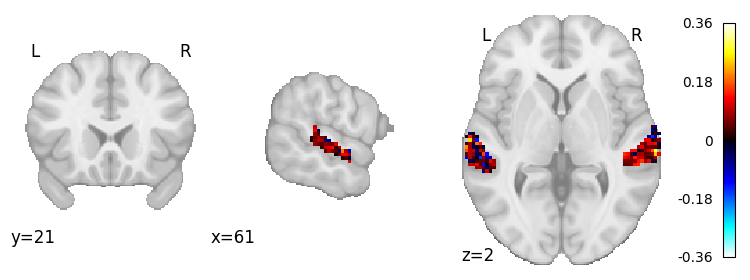

In [109]:
from nilearn.plotting import plot_stat_map

plot_stat_map(masker.inverse_transform(scores_combined[0]), cut_coords=[61, 21, 2], draw_cross=False)

In [111]:
# Mel-spectrogram scores
scores_combined[1].max()

0.341532606934612

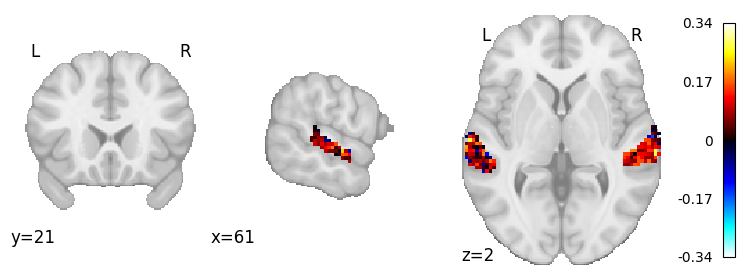

In [110]:
plot_stat_map(masker.inverse_transform(scores_combined[1]), cut_coords=[61, 21, 2], draw_cross=False)

# What's next?

The goal of this tutorial is to demonstrate how a banded regression model can be fit using `pyns.fetch_utils` and `himalaya. 

For a more comprehensive tutorial on the methods presented here, check out the excellent [voxelwise modeling tutorials](https://gallantlab.github.io/voxelwise_tutorials/index.html) from the Gallant Lab.

# Citing Neuroscout
Please ensure to cite Neuroscout if publishing any work using these data, and be aware that there are ongoing efforts to standardize the most common variations of voxel-wise encoding models, in order to enable users to fully specify and register their analysis in Neuroscout (like you currently can for summary-statistics multi-level GLM models). 